In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from skimage.transform import rotate

In [ ]:
epochs = 10
batch_size = 8
margin = 1  # Margin for constrastive loss.

In [ ]:
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()

# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x_test, y_test, test_size=0.2, random_state=9, stratify=y_test)

In [ ]:
# Keep 50% of train_val  in validation set
x_train, x_val = x_train_val[:6000], x_train_val[6000:]
y_train, y_val = y_train_val[:6000], y_train_val[6000:]
del x_train_val, y_train_val

In [ ]:
final_x_train = []

for i in tqdm(range(x_train.shape[0])):
    final_x_train.append(rotate(x_train[i], angle = 20))

100%|██████████| 6000/6000 [00:01<00:00, 3483.15it/s]


In [ ]:
final_x_train = np.array(final_x_train)

In [ ]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(final_x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [ ]:
pairs_train[0][1].shape

im_h = cv2.hconcat([pairs_train[1][0], pairs_train[1][1]])

Train Pair Augmentation With Label Number


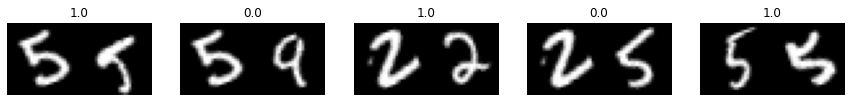

Validation Pair  With Label Number


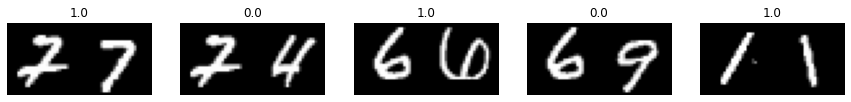

Test Pair  With Label Number


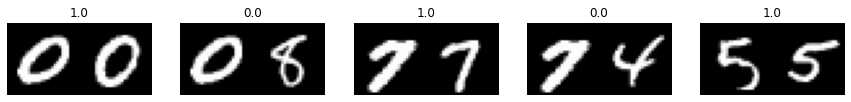

In [ ]:
a = 1  # number of rows
b = 5  # number of columns
c1 = 1  # initialize plot counter
c2 = 1
c3 = 1

print("Train Pair Augmentation With Label Number")

fig = plt.figure(figsize=(15,10))

for i in range(5):
    plt.subplot(a, b, c1)
    plt.title(labels_train[i])
    similar_train = cv2.hconcat([pairs_train[i][0], pairs_train[i][1]])
    plt.imshow(similar_train, cmap='gray')
    plt.axis('off')
    c1 = c1 + 1

plt.show()

print("Validation Pair  With Label Number")
fig = plt.figure(figsize=(15,10))

for i in range(5):
    plt.subplot(a, b, c2)
    plt.title(labels_val[i])
    similar_val = cv2.hconcat([pairs_val[i][0], pairs_val[i][1]])
    plt.imshow(similar_val, cmap='gray')
    plt.axis('off')
    c2 = c2 + 1

plt.show()

print("Test Pair  With Label Number")
fig = plt.figure(figsize=(15,10))
for i in range(5):
    plt.subplot(a, b, c3)
    plt.title(labels_test[i])
    similar_test = cv2.hconcat([pairs_test[i][0], pairs_test[i][1]])
    plt.imshow(similar_test, cmap='gray')
    plt.axis('off')
    c3 = c3 + 1

plt.show()

In [ ]:
x_train_1 = np.expand_dims(pairs_train[:, 0], 3)  # x_train_1.shape is (60000, 28, 28)
x_train_2 = np.expand_dims(pairs_train[:, 1], 3)

In [ ]:
x_val_1 = np.expand_dims(pairs_val[:, 0], 3)  # x_val_1.shape = (60000, 28, 28)
x_val_2 = np.expand_dims(pairs_val[:, 1], 3)

In [ ]:
x_test_1 = np.expand_dims(pairs_test[:, 0], 3)  # x_test_1.shape = (20000, 28, 28)
x_test_2 = np.expand_dims(pairs_test[:, 1], 3)

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 2, 2), w_pad=0)
    else:
        plt.tight_layout(rect=(0, 0, 1, 1))
    plt.show()

In [ ]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [ ]:
input = layers.Input((28, 28, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)

embedding_network = keras.Model(input, x)


input_1 = layers.Input((28, 28, 1))
input_2 = layers.Input((28, 28, 1))


tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
def loss(margin=1):


    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [ ]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])

siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 10)           5318        input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

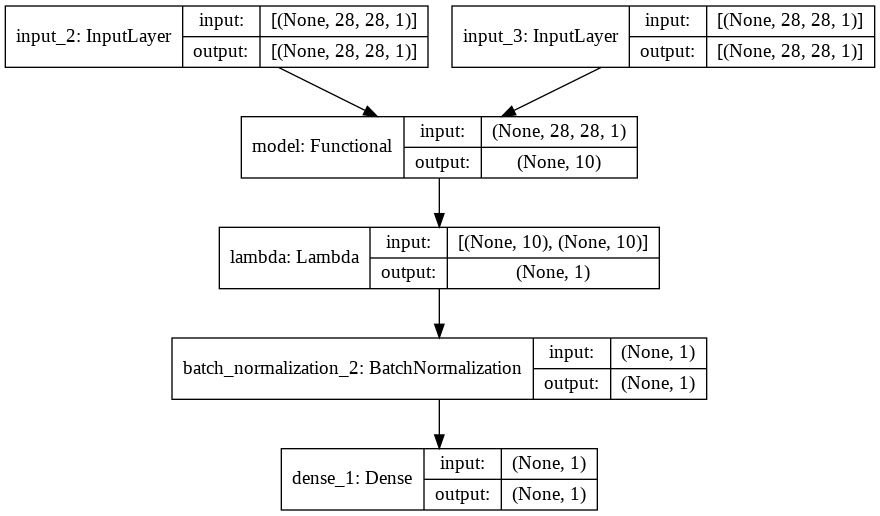

In [ ]:
tf.keras.utils.plot_model(siamese, to_file='Similarity_learning_MNIST.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = siamese.fit([x_train_1, x_train_2], labels_train, validation_data=([x_val_1, x_val_2], labels_val),
                      batch_size = 8, epochs=50)

Epoch 1/50
1500/1500 [==============================] - 43s 8ms/step - loss: 0.1620 - accuracy: 0.7769 - val_loss: 0.1340 - val_accuracy: 0.8048
Epoch 2/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1219 - accuracy: 0.8310 - val_loss: 0.1263 - val_accuracy: 0.8263
Epoch 3/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1049 - accuracy: 0.8582 - val_loss: 0.1045 - val_accuracy: 0.8545
Epoch 4/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0974 - accuracy: 0.8680 - val_loss: 0.1074 - val_accuracy: 0.8522
Epoch 5/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0879 - accuracy: 0.8817 - val_loss: 0.1027 - val_accuracy: 0.8583
Epoch 6/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0823 - accuracy: 0.8912 - val_loss: 0.0971 - val_accuracy: 0.8685
Epoch 7/50
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0808 - accuracy: 0.8926 - val_loss: 0.1033 - val_ac

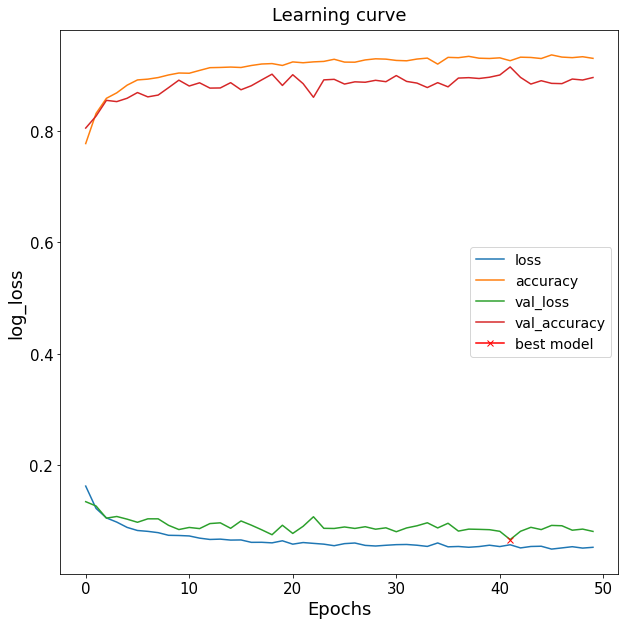

In [ ]:
title_font = {'fontname':'Arial', 'size':'18', 'color':'black', 'weight':'normal', 'verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'18', 'color':'black'}

# plt.figure(figsize=(10, 10))
fig = plt.figure(figsize=(10, 10))
plt.title("Learning curve", **title_font)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.tick_params(labelsize=15, labelcolor= "black")
plt.xlabel("Epochs", **axis_font)
plt.ylabel("log_loss", **axis_font)
plt.legend(loc="center right", prop={"size":14});
plt.show()
fig.savefig('Similarity_Learning.png', bbox_inches="tight")

In [ ]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

125/125 [==============================] - 1s 4ms/step - loss: 0.0788 - accuracy: 0.8975
test loss, test acc: [0.07875805348157883, 0.8974999785423279]


In [ ]:
predictions = siamese.predict([x_test_1, x_test_2])

Test Pair With Accuracy


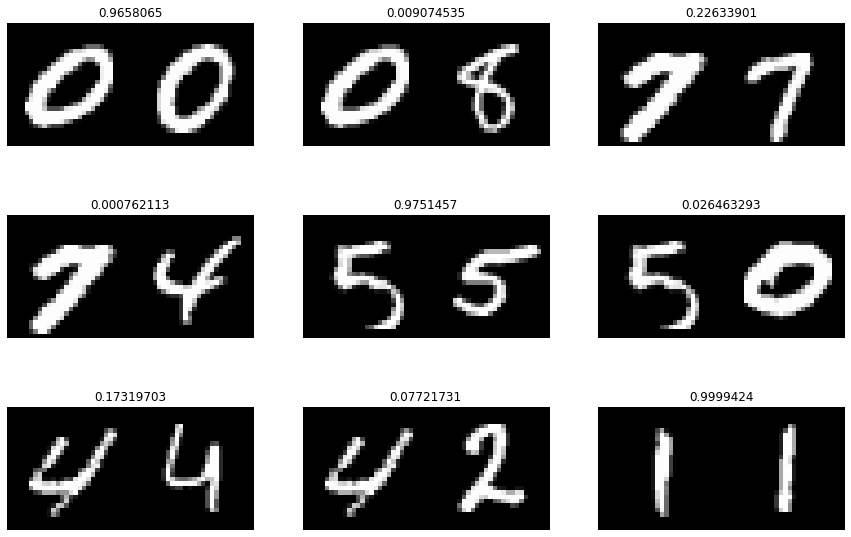

In [ ]:
C = 1

print("Test Pair With Accuracy")

fig = plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3, 3, C)
    plt.title(predictions[i][0])
    similar_test = cv2.hconcat([pairs_test[i][0], pairs_test[i][1]])
    plt.imshow(similar_test, cmap='gray')
    plt.axis('off')
    C = C + 1

plt.show()